In [1]:
import h5py

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device=}")

Using device=device(type='cpu')


In [3]:
background_dataset_name = 'background_dataset.h5'

In [4]:
with h5py.File(background_dataset_name) as f:
    X_test = f['X_test'][()]
    X_train = f['X_train'][()]
    X_val = f['X_val'][()]

# Reshape to have MET, particles, jets in the last dimension

In [5]:
X_test = torch.from_numpy(X_test.reshape(-1, 19, 3)).to(dtype=torch.float32, device=device).transpose(1, 2)
X_train = torch.from_numpy(X_train.reshape(-1, 19, 3)).to(dtype=torch.float32, device=device).transpose(1, 2)
X_val = torch.from_numpy(X_val.reshape(-1, 19, 3)).to(dtype=torch.float32, device=device).transpose(1, 2)

In [6]:
print(f"Num dimensions {X_train.shape[-1]}; Num dimensions {X_train.shape[-2]}")

Num dimensions 19; Num dimensions 3


In [7]:
class HEPDataSet(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset.clone()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        return self.dataset[idx]

In [8]:
train_set = HEPDataSet(X_train)
val_set = HEPDataSet(X_val)
test_set = HEPDataSet(X_test)

In [9]:
batch_size = 4000

train_data_loader = DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True,
)
val_data_loader = DataLoader(
    val_set, batch_size=batch_size,
    shuffle=True,
)

test_data_loader = DataLoader(
    test_set, batch_size=batch_size,
    shuffle=True,
)

In [10]:
print(f"Num batches for training = {len(train_data_loader)}")

Num batches for training = 2153


In [11]:
for idx, val in enumerate(train_data_loader):
    break

In [12]:
val.shape

torch.Size([4000, 3, 19])

# Define similarity loss

All of SM particles embedded to a space where we enforce similarity

In [13]:
# Simplified implemented from https://github.com/violatingcp/codec/blob/main/losses.py
class VICRegLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        repr_loss = F.mse_loss(x, y)

        x_mu = x.mean(dim=0)
        x_std = x.std(dim=0) + 1e-2
        y_mu = y.mean(dim=0)
        y_std = y.std(dim=0) + 1e-2
        
        x = (x - x_mu)/x_std
        y = (y - y_mu)/y_std

        N = x.size(0)
        D = x.size(-1)

        std_loss = torch.mean(F.relu(1 - x_std, inplace=False)) / 2
        std_loss += torch.mean(F.relu(1 - y_std, inplace=False)) / 2

        cov_x = (x.transpose(1, 2).contiguous() @ x) / (N - 1)
        cov_y = (y.transpose(1, 2).contiguous() @ y) / (N - 1)

        cov_loss = self.off_diagonal(cov_x).pow_(2).sum().div(D)
        cov_loss += self.off_diagonal(cov_y).pow_(2).sum().div(D)

        return repr_loss + cov_loss + std_loss

    def off_diagonal(self, x):
        num_batch, n, m = x.shape
        assert n == m
        # All off diagonal elements from complete batch flattened
        return x.flatten(start_dim=1)[...,:-1].view(num_batch, n - 1, n + 1)[...,1:].flatten()

In [14]:
vicreg_loss = VICRegLoss()

In [15]:
from nflows.nn.nets import ResidualNet
from nflows import transforms, distributions, flows

In [16]:
class SimilarityEmbedding(nn.Module):
    """An embedding with resnets"""
    def __init__(self):
        super().__init__()
        self.resnet = ResidualNet(19, 1, 100)

    def forward(self, x):
        res_embedding = self.resnet(x)
        return res_embedding

In [17]:
similarity_embedding = SimilarityEmbedding()

optimizer = torch.optim.Adam(similarity_embedding.parameters(), lr=1e-5)

scheduler_1 = torch.optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler_3 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [18]:
similarity_embedding(val).shape

torch.Size([4000, 3, 1])

In [19]:
def train_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        # only applicable to the final batch
        if val.shape[0] != batch_size:
            continue

        # embed entire batch with first value of the batch repeated
        first_val_repeated = val[0].repeat(batch_size, 1, 1)
        
        embedded_values_aug = similarity_embedding(first_val_repeated)
        embedded_values_orig = similarity_embedding(val)

        similar_embedding_loss = vicreg_loss(embedded_values_aug, embedded_values_orig)

        optimizer.zero_grad()
        similar_embedding_loss.backward()
        optimizer.step()
        # Gather data and report
        running_sim_loss += similar_embedding_loss.item()
        if idx % 500 == 0:
            last_sim_loss = running_sim_loss / 500
            print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_sim_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('SimLoss/train', last_sim_loss, tb_x)
            running_sim_loss = 0.
    return last_sim_loss


def val_one_epoch(epoch_index, tb_writer):
    running_sim_loss = 0.
    last_sim_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        if val.shape[0] != batch_size:
            continue

        first_val_repeated = val[0].repeat(batch_size, 1, 1)

        embedded_values_aug = similarity_embedding(first_val_repeated)
        embedded_values_orig = similarity_embedding(val)

        similar_embedding_loss = vicreg_loss(embedded_values_aug, embedded_values_orig)

        running_sim_loss += similar_embedding_loss.item()
        if idx % 50 == 0:
            last_sim_loss = running_sim_loss / 50
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('SimLoss/val', last_sim_loss, tb_x)
            tb_writer.flush()
            running_sim_loss = 0.
    tb_writer.flush()
    return last_sim_loss

In [20]:
# writer = SummaryWriter("hep_sim_together_round_2", comment="Similarity with LR=1e-3", flush_secs=5)
# epoch_number = 0

In [21]:
# %%time
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# EPOCHS = 10

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))
#     # Gradient tracking
#     similarity_embedding.train(True)
#     avg_train_loss = train_one_epoch(epoch_number, writer)
    
#     # no gradient tracking, for validation
#     similarity_embedding.train(False)
#     avg_val_loss = val_one_epoch(epoch_number, writer)
    
#     print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

#     epoch_number += 1
#     scheduler.step()

In [22]:
PATH = "./similarity_model_together.pt"
# torch.save(similarity_embedding.state_dict(), PATH)
similarity_embedding.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Plot embedded values for testing set

In [23]:
sim_vals = []

for idx, val in enumerate(test_data_loader, 1):
    if val.shape[0] != batch_size:
        continue
    with torch.no_grad():
        sim_val = similarity_embedding(val)
        sim_vals.append(sim_val)

In [24]:
sim_vals = torch.stack(sim_vals).reshape(len(sim_vals)*batch_size, 3)

In [25]:
sim_vals.shape

torch.Size([2688000, 3])

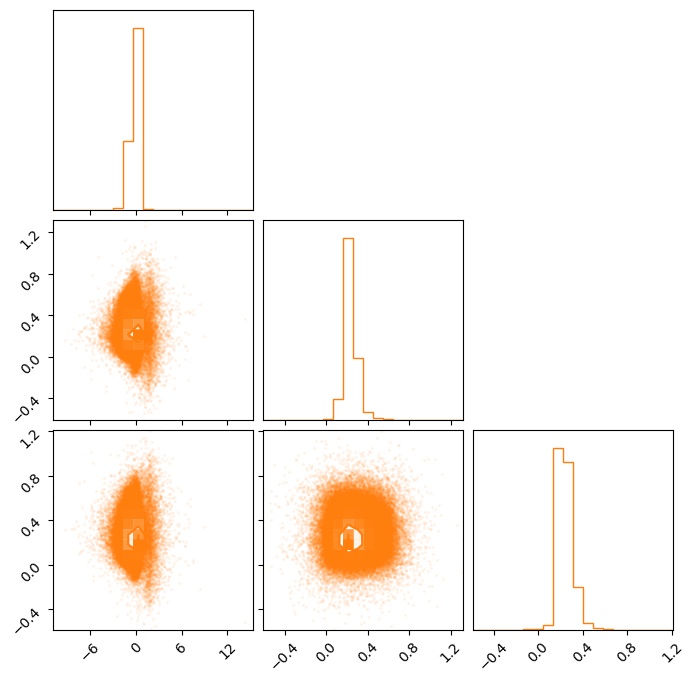

In [26]:
import corner

figure = corner.corner(
    sim_vals.numpy(), color="C1")

In [27]:
# helper function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [28]:
print(f"Num trainable parameters in embedding net: {count_parameters(similarity_embedding)}")

Num trainable parameters in embedding net: 42501


In [29]:
# Freeze weights for embedding net
for name, param in similarity_embedding.named_parameters():
    param.requires_grad = False

# Create small Normalizing flow to transform above latent space

This is used as a density estimation on the similar subspace

In [30]:
num_layers = 5
base_dist = distributions.StandardNormal(shape=[3])

transform_layers = []
for _ in range(num_layers):
    transform_layers.append(transforms.permutations.ReversePermutation(features=3))
    transform_layers.append(
        transforms.autoregressive.MaskedAffineAutoregressiveTransform(
            features=3,
            hidden_features=10
        )
    )

transform_obj = transforms.CompositeTransform(transform_layers)

flow_obj = flows.Flow(transform_obj, base_dist)

optimizer = torch.optim.Adam(flow_obj.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [31]:
print(f"Num training parameters in flow = {count_parameters(flow_obj)}")

Num training parameters in flow = 2730


In [32]:
# # UNCOMMENT AND RUN TO TRAIN FROM SCRATCH
# num_iter = 10
# for i in range(num_iter):
#     # use the val_data_loader from previous step; this is only for quicker training
#     # alternatively restrict to fewer batches from train data loader
#     for idx, val in enumerate(val_data_loader):
#         # to work with the reshaping below
#         if val.shape[0] != batch_size:
#             continue

#         sim_val = similarity_embedding(val).reshape(4000, 3)
#         optimizer.zero_grad()
#         loss = -flow_obj.log_prob(inputs=sim_val).mean()
#         loss.backward()
#         optimizer.step()
#     print(f"Avg. log prob = {-loss.item():.3f}")
#     scheduler.step()

In [33]:
FLOW_WEIGHTS = "./maf_flow.pt"
# torch.save(flow_obj.state_dict(), FLOW_WEIGHTS)
flow_obj.load_state_dict(torch.load(FLOW_WEIGHTS))

<All keys matched successfully>

# Check Foreground (BSM) vs Background (SM) data

Check and compare p-values for the SM and BSM particles

In [34]:
import numpy as np

In [35]:
# For SM testing set
# pick individual events from the test set and get p-val, stop at 50k
p_vals = []
for idx, val in enumerate(test_set, 1):
    if idx == 50000: break
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        p_vals.append(log_p)

# BSM dataset

Do the same for the BSM dataset, stop at 50k for each type of event. Also use 50k of SM events from testing set.

## $A \rightarrow 4l$

In [36]:
with h5py.File('signals_dataset.h5') as f:
    sig_test = f['Data'][()]

In [37]:
a_4l = torch.from_numpy(sig_test.reshape(sig_test.shape[0], 3, 19)).to(dtype=torch.float32)

In [38]:
a_4l_p_vals = []
for idx, val in enumerate(a_4l, 1):
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        a_4l_p_vals.append(log_p)

In [39]:
sm_p_vals = torch.stack(p_vals).flatten().numpy()
a_4l_p_vals = torch.stack(a_4l_p_vals).flatten().numpy()

In [40]:
print(f"A to 4L p-val median {np.median(a_4l_p_vals):.3f}")
print(f"A to 4L p-val mean {np.mean(a_4l_p_vals):.3f}")

A to 4L p-val median -96.738
A to 4L p-val mean -1028411424768.000


#### Comparing SM p-vals

In [41]:
print(f"SM p-val median {np.median(sm_p_vals):.3f}")
print(f"SM p-val mean {np.mean(sm_p_vals):.3f}")

SM p-val median 3.657
SM p-val mean 3.078


## $h \rightarrow \tau\tau$

In [42]:
with h5py.File('signals_hToTauTau_dataset.h5') as f:
    h_tau_tau = f['Data'][()]

In [43]:
h_tau_tau = torch.from_numpy(h_tau_tau.reshape(h_tau_tau.shape[0], 3, 19)).to(dtype=torch.float32, device=device)

In [44]:
h_tau_tau_p_vals = []
for idx, val in enumerate(h_tau_tau, 1):
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        h_tau_tau_p_vals.append(log_p)

In [45]:
h_tau_tau_p_vals = torch.stack(h_tau_tau_p_vals).flatten().numpy()

In [46]:
print(f"h to tau-tau p-val median {np.median(h_tau_tau_p_vals):.3f}")
print(f"h to tau-tau p-val mean {np.mean(h_tau_tau_p_vals):.3f}")

h to tau-tau p-val median -149.006
h to tau-tau p-val mean -1623752966144.000


## $h^{\pm} \rightarrow \tau\nu$

In [47]:
with h5py.File('signals_hChToTauTau_dataset.h5') as f:
    h_tau_nu = f['Data'][()]

In [48]:
h_tau_nu = torch.from_numpy(h_tau_nu.reshape(h_tau_nu.shape[0], 3, 19)).to(dtype=torch.float32)

In [49]:
h_tau_nu_p_vals = []
for idx, val in enumerate(h_tau_nu, 1):
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        h_tau_nu_p_vals.append(log_p)

In [50]:
h_tau_nu_p_vals = torch.stack(h_tau_nu_p_vals).flatten().numpy()

In [51]:
print(f"h to tau-nu p-val median {np.median(h_tau_nu_p_vals):.3f}")
print(f"h to tau-nu p-val mean {np.mean(h_tau_nu_p_vals):.3f}")

h to tau-nu p-val median -372.200
h to tau-nu p-val mean -106421528142299529216.000


## $LQ \rightarrow b\tau$

In [52]:
with h5py.File("signals_leptoquark_dataset.h5") as f:
    leptoquark = f['Data'][()]

In [53]:
leptoquark = torch.from_numpy(leptoquark.reshape(leptoquark.shape[0], 3, 19)).to(dtype=torch.float32, device=device)

In [54]:
leptoquark_p_vals = []
for idx, val in enumerate(leptoquark, 1):
    with torch.no_grad():
        log_p = flow_obj.log_prob(similarity_embedding(val).reshape(1, 3))
        leptoquark_p_vals.append(log_p)

In [55]:
leptoquark_p_vals = torch.stack(leptoquark_p_vals).flatten().numpy()

In [56]:
print(f"LQ to b-tau p-val median {np.median(leptoquark_p_vals):.3f}")
print(f"LQ to b-tau p-val mean {np.mean(leptoquark_p_vals):.3f}")

LQ to b-tau p-val median -167.808
LQ to b-tau p-val mean -329009312.000


# Efficiency vs. False alarm of all BSM events

### Restricting scale of the plot

Here, the plot is zoomed to higher p-values. Most of the BSM distribution has significantly negative p-vals.

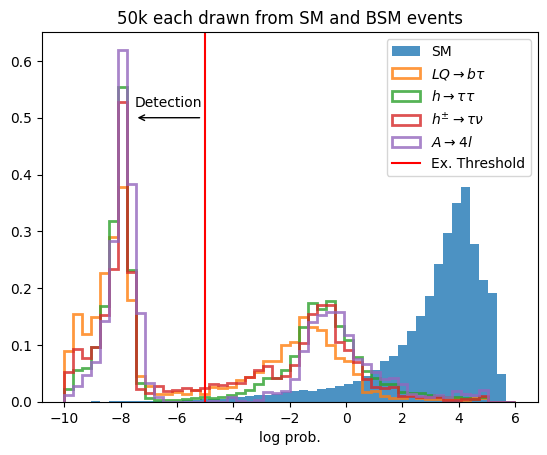

In [57]:
plt.hist(sm_p_vals, range=(-10, 6), bins=50, label='SM',
         density=True, alpha=0.8)
plt.hist(leptoquark_p_vals, range=(-10, 6), bins=50, label='$LQ \\rightarrow b\\tau$',
         density=True, alpha=0.8, histtype='step', linewidth=2)
plt.hist(h_tau_tau_p_vals, range=(-10, 6), bins=50, label='$h \\rightarrow \\tau\\tau$',
         density=True, alpha=0.8, histtype='step', linewidth=2)
plt.hist(h_tau_nu_p_vals, range=(-10, 6), bins=50, label='$h^{\pm} \\rightarrow \\tau\\nu$',
         density=True, alpha=0.8, histtype='step', linewidth=2)
plt.hist(a_4l_p_vals, range=(-10, 6), bins=50, label='$A \\rightarrow 4l$',
         density=True, alpha=0.8, histtype='step', linewidth=2)
plt.title("50k each drawn from SM and BSM events")
plt.axvline(-5, label='Ex. Threshold', color='red')
plt.annotate("", xy=(-5.1, 0.5), xytext=(-7.5, 0.5),
             arrowprops=dict(arrowstyle="<-"))
plt.text(-7.5, 0.52, "Detection")
plt.xlabel("log prob.")
plt.legend()

In [58]:
from itertools import cycle

colors = cycle(['red', 'green', 'blue', 'black'])
linestyles = cycle(['--', '-.', ':', '-'])

In [59]:
thresholds = np.linspace(-300, 6, 500)

p_vals = {
    'h_tau_tau': h_tau_tau_p_vals,
    'h_tau_nu': h_tau_nu_p_vals,
    'A_4l': a_4l_p_vals,
    'leptoquark': leptoquark_p_vals
}

efficiencies = dict.fromkeys(p_vals)
false_alarms = dict.fromkeys(p_vals)


for k, p_val in p_vals.items():
    eff = []
    false = []
    for threshold in thresholds:
        _eff = np.sum(p_val < threshold)
        _false = np.sum(sm_p_vals < threshold)
        eff.append(_eff)
        false.append(_false)
    efficiencies[k] = np.array(eff)/len(p_val)
    false_alarms[k] = np.array(false)/len(p_val)

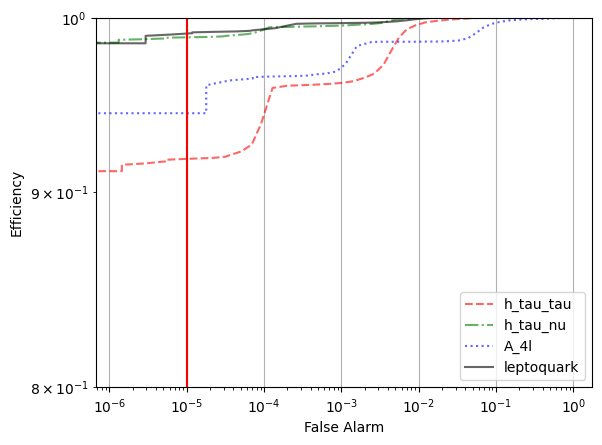

In [60]:
plt.figure()

for k in efficiencies:
    plt.loglog(false_alarms[k], efficiencies[k], label=k,
               color=next(colors), linestyle=next(linestyles), alpha=0.6)

plt.legend()
plt.ylim((0.8, 1))
plt.ylabel("Efficiency")
plt.xlabel("False Alarm")
plt.axvline(x=1e-5, c='r')
plt.grid()